In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import make_grid

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
pretrained_model = "../model/googlefonts.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [5]:
def attack(data, data_grad, target, dirname_res, dirname_pro, chr, count, epsilon, lim, success):
    os.makedirs(dirname_pro + chr + "/{}".format(count), exist_ok=True)
    # os.makedirs(dirname_pro + chr + "/{}".format(i), exist_ok=True)
    for i in range(1, 10001):
        data.requires_grad = False
        sign_data_grad = data_grad.sign()
        perturbed_data = data + epsilon * sign_data_grad
        # perturbed_data += (perturbed_data < torch.Tensor([1 - lim]).to("cuda")) * epsilon + (perturbed_data < torch.Tensor([0]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([-1 + lim]).to("cuda")) * -epsilon + (perturbed_data > torch.Tensor([0]).to("cuda")) * epsilon
        perturbed_data = torch.clamp(perturbed_data, -1, 1)
        data = perturbed_data
        data.requires_grad = True
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_pro + chr + "/{}".format(count) + "/" + "{}.png".format(i), data.squeeze().detach().cpu().numpy(), cmap="gray")
        if pred.item() != target.item():
            success += 1
            break
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
    os.makedirs(dirname_res + chr + "/{}".format(i), exist_ok=True)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imsave(dirname_res + chr + "/{}".format(i) + "/" + "{}.png".format(count), data.squeeze().detach().cpu().numpy(), cmap="gray")
    return data, pred, success

In [6]:
def test(model, device):
    chr_lambda = lambda a: chr(a + 65)
    dirname_grad = "../attack_result" + "/grad/"
    dirname_org = "../attack_result" + "/org/"
    dirname_adv = "../attack_result" + "/adv/"
    dirname_res = "../attack_result" + "/resistance/"
    dirname_pro = "../attack_result" + "/progress/"
    for c in [chr(i) for i in range(65, 65+26)]:
        os.makedirs(dirname_grad + c, exist_ok=True)
        os.makedirs(dirname_org + c, exist_ok=True)
        os.makedirs(dirname_adv + c, exist_ok=True)
        os.makedirs(dirname_res + c, exist_ok=True)
        os.makedirs(dirname_pro + c, exist_ok=True)
        for d in [chr(i) for i in range(65, 65+26)]:
            os.makedirs(dirname_adv + c + "/" + c + "→" + d, exist_ok=True)


    class ImageTransform():
        def __init__(self, mean, std):
            self.data_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Resize((64, 64)),
            transforms.Normalize(mean, std)
            ])

        def __call__(self, img):
            return self.data_transform(img)
    mean = (0.5,)
    std = (0.5,)
    images_test = ImageFolder( "../data/GoogleFonts/test", transform = ImageTransform(mean, std))
    batch_size = 1
    test_loader = DataLoader(images_test, batch_size = batch_size, shuffle = False, drop_last=True)

    # 精度カウンター
    correct = 0
    success = 0
    # count = 0
    count_list = [0] * 26

    adv_examples = []
    # i=0
    a_list = []
    # テスト用データセット内の全てのサンプルをループします
    for data, target in tqdm(test_loader, total = 30862):

        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.type(torch.LongTensor).to(device)
        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。

        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        
        if init_pred.item() != target.item() or target.item() != 0:
            continue

        correct += 1

        data_copy = data.detach().clone()
        # character_coordinate = character_search(data_copy.data[0][0])

        count_list[init_pred.item()] += 1
    
        # 損失を計算します
        loss = F.nll_loss(output, target)
        # 既存の勾配を全てゼロにします
        model.zero_grad()
        # 逆伝播させてモデルの勾配を計算します
        loss.backward()
        # データの勾配を取得します
        data_grad = data.grad.data
        
        # # 勾配のヒートマップ
        # grad_map = data_grad.squeeze().detach().cpu().numpy()
        # grad_map_abs = np.abs(grad_map)
        # plt.xticks([], [])
        # plt.yticks([], [])
        # plt.imsave(dirname_grad + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), grad_map_abs, cmap="Reds")

        perturbed_data, pred, success = attack(data, data_grad, target, dirname_res, dirname_pro, chr_lambda(init_pred.item()), count_list[init_pred.item()], 0.001, 0, success)

        final_pred = pred

        org = data_copy.squeeze().detach().cpu().numpy()
        adv = perturbed_data.squeeze().detach().cpu().numpy()

        #各条件を満たす画像の保存
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_org + chr_lambda(init_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), org, cmap="gray")
        
        os.makedirs(dirname_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/", exist_ok=True)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_adv + chr_lambda(init_pred.item()) + "/" + chr_lambda(init_pred.item()) + "→" + chr_lambda(final_pred.item()) + "/{}.png".format(count_list[init_pred.item()]), adv, cmap="gray")

# print(success)
# print("Test Accuracy = {} / 30862 = {}".format(correct, correct / 30862))
# print("Attack Success = {} / {} = {}".format(success, correct, success / correct))

100%|██████████| 30862/30862 [34:43<00:00, 14.81it/s]  


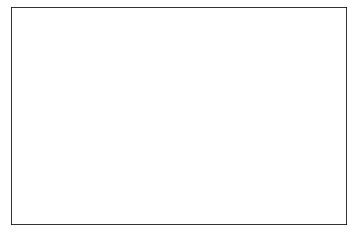

In [7]:
# 各epsilonごとにテストを実行
test(model, device)